# SU(d)  Dicke state $|D^{n}(\vec{k})\rangle$ preparation: QPE - $O(log(n))$ depth

Cirq implementation of a circuit in:

"Simple ways of preparing qudit Dicke states", https://arxiv.org/abs/2507.13308

by Noah B. Kerzner, Federico Galeazzi and Rafael I. Nepomechie

Code written by Noah Kerzner

In [ ]:
pip install cirq

In [4]:
import matplotlib.pyplot as plt
import cirq
import numpy as np
from collections import Counter
from functools import reduce
from scipy.linalg import expm


def h(i: int, d: int) -> np.ndarray:
    """
    Returns the projector |i><i| for a qudit of dimension d.

    Args:
        i (int): Index of the basis state (0 ≤ i < d).
        d (int): Dimension of the qudit Hilbert space.

    Returns:
        np.ndarray: A d x d matrix representing the projector |i><i|.
    """
    if not (0 <= i < d):
        raise ValueError("Index i must be in the range 0 ≤ i < d")
    
    vec = np.zeros((d, 1), dtype=complex)
    vec[i, 0] = 1.0
    return vec @ vec.conj().T  # |i⟩⟨i|



def full_U(i:int,l:int,d:int,n:int, anc_qubs: list[cirq.LineQubit], working_vec: cirq.LineQid):
    
    h_k=h(i+1,d)

    for p, qub in enumerate(anc_qubs[i]):

        for k in range(n):

            

            U=expm(2j * np.pi * h_k / (2**l)*(2**(l - p - 1)))
            
            
            yield cirq.ControlledGate(
                cirq.MatrixGate(U,name=f"U_{i}^{(2**(l - p - 1))}",qid_shape=(d,)),
                control_values=(1,),
                control_qid_shape=(2,)
            ).on(qub, working_vec[k])




def qpe(num_qubs: int, d: int,n:int,  working_vec: list[cirq.Qid], mode=0):


    anc_qubs=[]


    for i in range(d-1):

        temp=[]
        for j in range(num_qubs):
            temp.append(cirq.LineQubit(i*num_qubs+j))

        anc_qubs.append(temp)


    
    # Apply Hadamards to ancillas
    for quds in anc_qubs:
        for qud in quds:
            yield cirq.H.on(qud)

    #Apply controlled-U^{d^i}
    for i in range(d-1):
        yield full_U(i,num_qubs,d,n,anc_qubs,working_vec)

    for qubs in anc_qubs:

        yield cirq.qft(*qubs, inverse=True)


    if mode==0: # mode to measure or not 
        # Measure

        for i,qubs in enumerate(anc_qubs):
            yield cirq.measure(*qubs, key=f'k_{i+1}_estimate')
        
        yield cirq.measure(working_vec,key='dicke')



class ditrotation(cirq.Gate):
    def __init__(self, theta, i, j, d):
        if i == j or not (0 <= i < d) or not (0 <= j < d):
            raise ValueError("Indices i and j must be different and in range [0, d-1]")
        super().__init__()
        self.theta = theta
        self.i = i
        self.j = j
        self.d = d

    def _qid_shape_(self):
        return (self.d,)

    def _unitary_(self):
        U = np.eye(self.d, dtype=np.complex128)
        c, s = np.cos(self.theta / 2), np.sin(self.theta / 2)
        U[self.i, self.i] = c
        U[self.j, self.j] = c
        U[self.i, self.j] = -s
        U[self.j, self.i] = s
        return U

    def _circuit_diagram_info_(self, args):
        return f"R{self.i}{self.j}({self.theta:.2f})"





def get_dit_thetas(n:int ,k:np.ndarray):
        thetas = []

        zs=[np.sqrt(k[i]/n) for i in range(len(k)-1)]

        for z in  zs:

            if z == 0:
                thetas.append(np.pi)
                continue

            denom = list_prod(thetas)
            
            if denom < 1e-10:
                thetas.append(0)
                continue

            val = z/ denom
            val = np.clip(val, -1, 1)
            theta = 2 * np.arccos(val)

            thetas.append(theta)

        #print(f'gamms/thetas for i= {i}, p= {p}\n{gamms}\n{thetas}\n')
        return thetas




def list_prod(arr):
    """Helper function for angle calculations 

    Args:
        arr (float): list of already calculated thetas

    Returns:
        float: helper product
    """    
    ret = 1
    for arg in arr:
        ret *= np.sin(arg / 2)
    return ret




def init_qud(quds:cirq.LineQid, k_vec,n,d):

    thetas=get_dit_thetas(n,k_vec)


    for i,theta in enumerate(thetas):
        for qud in quds:
            yield ditrotation(theta,i,i+1,d).on(qud)




def dicke_simulate(k: tuple):
    """
    runs the qpe algo for the dicke state but does not measure.

    - The function ouptuts the final state pre measurment of the total system
    - the order is ancilary qubits then working qubits

    Args:
        n (int): number of working qubits
        k (int): desired number of 1's in dicke state
    """


    n=sum(k)
    d=len(k)

    l=int(np.ceil(np.log(n + 1)/np.log(2)))


    quds=[]
    for i in range(n):
        quds.append(cirq.LineQid((d-1)*l+i,dimension=d))

    circuit=cirq.Circuit()


    circuit.append(init_qud(quds,k,n,d))

    circuit.append(qpe(l,d,n,quds,1))

    # Simulate
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    print(circuit)
    print(cirq.dirac_notation(result.final_state_vector, qid_shape=(2,) * (l*(d-1)) + (d,)*n))


def dicke_shots(k:tuple,shots=10,mode=0): # mode=0 for full distrobution, mode = 1 for expected k distrobution
    """runs repeated qpe alogirthm to make bar graph of final vector measurment and l

    - Mode = 0 prints a bar graph of the total probability distrobution (all k's and all state vectors)
    - Mode = 1 prints a bar graph of the probabiliyt distrobution only for the measurments in the expected k

    Args:
        k (tuple): k vector for set
        shots (int, optional): amount of instances of the QPE algorithm. Defaults to 10.
        mode (int, optional): mode of operation. Defaults to 0.
    """    
    
    n=sum(k)
    d=len(k)

    l=int(np.ceil(np.log(n + 1)/np.log(2)))


    quds=[]
    for i in range(n):
        quds.append(cirq.LineQid((d-1)*l+i,dimension=d))

    circuit=cirq.Circuit()


    circuit.append(init_qud(quds,k,n,d))

    circuit.append(qpe(l,d,n,quds,0))

    # Simulate
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)


    bitstrings = [["".join(str(bit) for bit in bits) for bits in result.measurements[f'k_{i+1}_estimate']] for i in range(d-1)]
    
    counts = [Counter(bits) for bits in bitstrings]
    most_common_ks = [count.most_common(1)[0][0] for count in counts]
    estimated_ks = [int(most_common_k, 2) for most_common_k in most_common_ks]
    estimated_ks.insert(0,n-sum(estimated_ks))

    dicke_bits = result.measurements['dicke']
    if mode == 1:
        dickes_meas = [
        "".join(str(bit) for bit in bits)
        for bits in dicke_bits
        if sum(bits) == k  # keep only bitstrings with exactly k ones
    ]
    else:
        dickes_meas = ["".join(str(bit) for bit in bits) for bits in dicke_bits]

    dickes=Counter(dickes_meas)
    print(f'Most Common k_vector: {estimated_ks} ')
    print(f' Distribution of measured Dicke state: {dickes}')
    analyze_counters(dickes, estimated_ks)


def analyze_counters( dickes: Counter, estimated_k: int):
    """Function to make bar graph of measurment results

    Args:
        counter2 (Counter): counted and ordered dicke measrument results 
        estimated_k (int): most probable k from measurment
    """    
    # Print most common value from counter1

    #print(estimated_k)
    # Plot histogram from counter2
    labels, values = zip(*dickes.items())
    plt.bar(labels, values)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(f'Distribution of final state vectors for k ≈ {estimated_k}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



# Examples

In [5]:
# Example without measurement
# n=3, d=3

k=(1,1,1)
dicke_simulate(k)

# The target state, expressed in Dirac notation, is given in this example by
#
# |k_1 k_2⟩|D^n (k_0, k_1, k_2)⟩ =|1 1⟩|D^3 (1,1,1)⟩ = |0101⟩ (0.41|012⟩ + 0.41|021⟩ + 0.41|102⟩ + 0.41|120⟩ + 0.41|201⟩ + 0.41|210⟩)
#
# = 0.41|0101012⟩ + 0.41|0101021⟩ + 0.41|0101102⟩ + 0.41|0101120⟩ + 0.41|0101201⟩ + 0.41|0101210⟩
#
# Note, however, that this algorithm prepares a superposition of all Dicke states (k_1, k_2) = (0,0), ..., (3,0)
# with k_0 = 3 - k_1 - k_2
# The ancillas must still be measured, with success on |k_1 k_2⟩=|1 1⟩= |0101⟩, in order to project to the target state.


                                            ┌──────────┐   ┌───────────────┐   ┌───────────────┐   ┌───────────┐
0: ─────────H───────────────────────@────────@──────────────@───────────────────────────────────────qft^-1──────────────────────────
                                    │        │              │                                       │
1: ─────────H───────────────────────┼────────┼────@─────────┼────@──────────────@───────────────────#2──────────────────────────────
                                    │        │    │         │    │              │
2: ─────────H───────────────────────┼────────┼────┼─────────┼────┼────@─────────┼────@──────────────@──────────────────────qft^-1───
                                    │        │    │         │    │    │         │    │              │                      │
3: ─────────H───────────────────────┼────────┼────┼─────────┼────┼────┼─────────┼────┼────@─────────┼─────@────────@───────#2───────
                                    │        │

Most Common k_vector: [1, 1, 2] 
 Distribution of measured Dicke state: Counter({'2222': 51, '2212': 34, '1222': 31, '2220': 29, '2221': 29, '2022': 29, '2202': 28, '2122': 28, '0222': 24, '1122': 23, '0220': 21, '0212': 19, '1220': 19, '2201': 19, '0022': 18, '2012': 18, '2200': 17, '2021': 17, '2120': 17, '2112': 17, '0202': 16, '1212': 16, '1221': 16, '1202': 15, '2020': 15, '2211': 15, '2210': 15, '1022': 15, '2102': 14, '2121': 13, '1002': 12, '0122': 12, '0102': 12, '2101': 12, '1200': 12, '0002': 11, '0121': 11, '0101': 11, '0221': 11, '2000': 10, '2001': 10, '2002': 10, '2110': 9, '1201': 9, '2111': 9, '2010': 9, '0210': 9, '1120': 9, '0012': 9, '0020': 9, '2100': 8, '1121': 8, '0211': 8, '0201': 8, '1001': 8, '0021': 8, '1101': 7, '0120': 7, '1020': 7, '1021': 7, '1211': 6, '1110': 6, '1012': 6, '0000': 5, '1210': 5, '2011': 5, '0112': 5, '1102': 5, '1111': 5, '1112': 5, '0111': 4, '0200': 4, '1010': 4, '1011': 3, '0100': 3, '1000': 2, '0110': 2, '0011': 2, '0010': 1, '1100': 

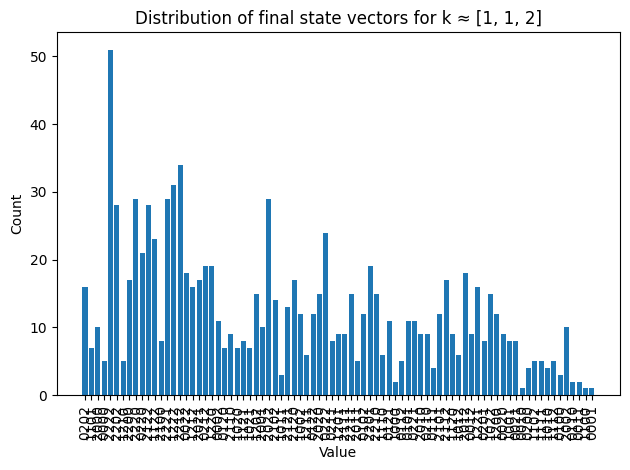

In [6]:
# Example with measurement
# n=4, d=3

k=(1,1,2)
dicke_shots(k,1000)

# The target state is 
#
# |k_1 k_2⟩|D^n (k_0, k_1, k_2)⟩ =|1 2⟩|D^3 (1,1,2)⟩

# =|0110⟩ 0.29(|0122⟩ + |0212⟩ + |0221⟩ + |1022⟩ + |1202⟩ + |1220⟩ + |2012⟩ + |2021⟩ + |2102⟩ + |2120⟩ + |2201⟩ + |2210⟩)
